# Classifying which Veterans enroll in the VA
---

This is the biggest question.  If we can identify traits based on which veterans enroll and which do not could have impact on getting vets the help that they need.

In [1]:
# import libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVR, LinearSVR, SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# Read in dataset.  In this case the 5yr veteran dataset is being used
vet = pd.read_csv("../working_data/vets_5yr_clean.csv")

'''Additional viewing options'''
# This code sets the notebook to display maximum columns.  Uncomment it to see trunacted view
pd.set_option('display.max_columns', len(vet))  

# This resets the view to a truncated output
#pd.reset_option('display.max_rows')

vet.head()

,REGION,DIVISION,CIT,COW,DEAR,DEYE,WKW,DOUT,DPHY,DRAT,RAC1P,DRATX,DREM,ENG,MLPK,HINS1,HINS2,MLPB,MLPCD,HINS3,HINS4,HINS5,HINS6,JWRIP,LANX,MAR,MARHD,MARHT,MARHW,MIL,MLPA,MLPE,MLPFG,MLPH,MLPI,NWLK,SCH,SCHL,SEX,WRK,MSP,VPS,ESR,HICOV,MLPJ,SERIALNO,SEMP_adj,PINCP_adj,PERNP_adj,WAGP_adj,SSIP_adj,SSP_adj,RETP_adj,PAP_adj,OIP_adj,INTP_adj,PUMA,ST,ADJINC,PWGTP,AGEP,DDRS,WKHP,WKL,DIS,HISP,NATIVITY,OC,POVPIP,RACAIAN,RACASN,RACBLK,RACNH,RACNUM,RACSOR,RACWHT,SCIENGP,SCIENGRLP,WAOB,FCITP,FHINS5C,FHINS5P,FHINS6P,FMARHYP,FMILPP,FMILSP,FPUBCOVP,REGION_2,REGION_3,REGION_4,DIVISION_2,DIVISION_3,DIVISION_4,DIVISION_5,DIVISION_6,DIVISION_7,DIVISION_8,DIVISION_9,CIT_2,CIT_3,CIT_4,CIT_5,COW_1,COW_2,COW_3,COW_4,COW_5,COW_6,COW_7,COW_8,COW_9,DEAR_2,DEYE_2,WKW_1,WKW_2,WKW_3,WKW_4,WKW_5,WKW_6,DOUT_2,DPHY_2,DRAT_1,DRAT_2,DRAT_3,DRAT_4,DRAT_5,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,DRATX_2,DREM_2,ENG_1,ENG_2,ENG_3,ENG_4,MLPK_0,MLPK_1,HINS1_2,HINS2_2,MLPB_0,MLPB_1,MLPCD_0,MLPCD_1,HINS3_2,HINS4_2,HINS5_2,HINS6_2,JWRIP_1,JWRIP_2,LANX_2,MAR_1,MAR_2,MAR_3,MAR_4,MARHD_1,MARHD_2,MARHT_1,MARHT_2,MARHT_3,MARHW_1,MARHW_2,MIL_2,MIL_3,MLPA_0,MLPA_1,MLPE_0,MLPE_1,MLPFG_0,MLPFG_1,MLPH_0,MLPH_1,MLPI_0,MLPI_1,NWLK_1,NWLK_2,SCH_2,SCH_3,SCHL_2,SCHL_3,SCHL_4,SCHL_5,SCHL_6,SCHL_7,SCHL_8,SCHL_9,SCHL_10,SCHL_11,SCHL_12,SCHL_13,SCHL_14,SCHL_15,SCHL_16,SCHL_17,SCHL_18,SCHL_19,SCHL_20,SCHL_21,SCHL_22,SCHL_23,SCHL_24,SEX_2,WRK_1,WRK_2,MSP_1,MSP_2,MSP_3,MSP_4,MSP_5,VPS_1,VPS_2,VPS_3,VPS_4,VPS_5,VPS_6,VPS_7,VPS_8,VPS_9,VPS_10,VPS_11,VPS_12,VPS_13,VPS_14,VPS_15,ESR_1,ESR_2,ESR_3,ESR_4,ESR_5,HICOV_2,MLPJ_0,MLPJ_1
0,1,2,1,7,2,2,4,2,2,-99,1,2,2,-99,0,1,1,0,0,1,2,2,2,1,2,1,2,1,2,2,1,0,0,0,0,2,1,16,1,1,1,1,1,1,0,2014000000261,0.0,9743.1243,1177.7403,1177.7403,0.0,0.0,0.0000,0.0,0.000,0.0,400,42,1070673,5,30,2,11.0,1,2,0,1.0,0,288.0,0,0,0,0,1,0,1,-99,-99,1,0,-99,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,1,1,0,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,1,2,1,-99,2,2,-99,2,2,-99,6,2,2,1,0,1,1,0,0,1,2,2,1,0,1,1,2,2,2,2,0,0,0,0,0,2,1,20,1,2,1,11,0,1,1,2014000000366,0.0,26766.8250,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.000,0.0,102,42,1070673,13,87,2,-99.0,0,2,0,1.0,0,222.0,0,1,0,0,1,0,0,-99,-99,1,0,-99,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,1,2,1,1,2,2,1,2,2,-99,1,2,2,-99,0,1,2,0,0,1,2,2,1,1,2,2,2,2,1,2,0,1,0,0,0,-99,1,19,1,1,3,6,1,1,0,2014000000660,0.0,97002.9738,80300.4750,80300.4750,0.0,0.0,0.0000,0.0,6424.038,0.0,1807,42,1070673,14,67,2,70.0,1,2,0,1.0,0,501.0,0,0,0,0,1,0,1,-99,-99,1,0,-99,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,1,2,1,-99,1,2,-99,1,1,-99,1,2,1,-99,0,2,1,0,0,1,2,2,2,0,2,1,2,1,2,2,0,0,1,0,0,2,1,16,1,2,1,13,0,1,0,2014000000788,0.0,1391.8749,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.000,0.0,200,42,1070673,5,80,2,-99.0,0,1,0,1.0,0,110.0,0,0,0,0,1,0,1,-99,-99,1,0,-99,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,1,0,0,1,1,0,0,0,0,1,1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,1,2,1,-99,1,2,-99,2,1,-99,1,2,2,-99,-99,1,1,-99,-99,1,2,2,2,0,2,1,2,1,2,3,-99,-99,-99,-99,-99,2,1,16,1,2,1,-99,0,1,-99,2014000001024,0.0,26552.690

# Feature Groups
---
The PUMs dataset is incredibly feature rich.  However, this also makes makes it unwieldy when the desire is only test a specific group of features.  For the sake of simplication, I grouped all of the features into groups, to make for simpler modeling.  Additionally, there are 2 versions of the groups:

* **Non-Encoded** - This uses all categorical features in their orginal state.
* **One Hot Encoded** - This uses expanded categorical variables.

#### Group Definitions

* **Veteran Specific Features** = ```veteran``` 
* **Health and Well Being Features** = ```health```
* **Employment and Income Features** = ```work_income```
* **Ethnicity Features** = ```ethnicity```
* **Lifestyle Features** = ```lifestyle```
* **Geographic Location Features** = ```location```
* **General Demographic Features** = ```general```
* **Education Features** = ```education```




In [3]:
'''The feature names in this data set are genreally hard to read.  
This code block puts them into lists of corresponding variables.'''

# Non-encoded variables
veteran = ['DRAT', 'DRATX', 'HINS6', 'MIL', 'MLPA', 'MLPB', 'MLPCD', 'MLPE', 'MLPFG', 'MLPH', 'MLPI', 'MLPJ', 'MLPK',
          'VPS', 'FHINS5C', 'FHINS5P', 'FHINS6P', 'FMILSP']
health = ['DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DRAT', 'DREM', 'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 'HINS6', 
          'MIG', 'DIS', 'HICOV']
work_income = ['COW', 'INTP_adj', 'OIP_adj', 'NWAB', 'NWLK', 'PAP_adj', 'RETP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj', 
              'WAGP_adj', 'WKHP', 'WKL', 'WKW', 'WRK', 'PINCP', 'PERNP', 'POVPIP', 'ESR']
ethnicity = ['CIT', 'ENG', 'HISP', 'RAC1P', 'RACAIAN', 'RACASN', 'RACBLK', 'RACNH', 'RACNUM', 'RACPI', 'RACSOR', 'RACWHT', 
            'FCITP', 'LANX']
lifestyle = ['JWRIP_1', 'JWRIP_2', 'MAR_1',	'MAR_2', 'MAR_3', 'MAR_4', 'MARHD', 'MARHT', 'MARHW', 'MSP']
location = ['DIVISION', 'REGION', 'ST', 'PUMA', 'intercept']
general = ['AGEP', 'MAR', 'SEX']
education = ['SCH', 'SCHL', 'SCIENGP', 'SCIENGRLP']

# One Hot Encoded variables
veteran_e = ['DRAT', 'DRATX_2', 'HINS6_2', 'MIL_2', 'MIL_3', 'MLPA_0', 'MLPA_1', 'MLPB_0', 'MLPB_1', 'MLPCD_0', 'MLPCD_1', 'MLPE_0',
             'MLPE_1', 'MLPFG_0', 'MLPFG_1', 'MLPH_0', 'MLPH_1', 'MLPI_0', 'MLPI_1', 'MLPJ_0', 'MLPJ_1', 'MLPK_0', 'MLPK_1',
             'VPS_1', 'VPS_2', 'VPS_3', 'VPS_4', 'VPS_5', 'VPS_6', 'VPS_7', 'VPS_8', 'VPS_9', 'VPS_10', 'VPS_11', 'VPS_12', 
             'VPS_13', 'VPS_14', 'VPS_15', 'ESR_1',	'ESR_2', 'ESR_3', 'ESR_4', 'ESR_5', 'FHINS5C', 'FHINS5P', 'FHINS6P', 
             'FMILSP']
health_e = ['DDRS', 'DEAR_2', 'DEYE', 'DOUT_2', 'DPHY_2', 'DRAT', 'DREM_2', 'HINS1_2', 'HINS2_2', 'HINS3_2', 'HINS4_2', 
            'HINS5_2', 'HINS6_2', 'DIS', 'HICOV_2']
work_income_e = ['COW_1', 'COW_2', 'COW_3', 'COW_4', 'COW_5', 'COW_6', 'COW_7', 'COW_8', 'COW_9', 'INTP_adj', 'OIP_adj', 
                  'NWLK_1', 'NWLK_2', 'PAP_adj', 'RETP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj', 
                 'WAGP_adj', 'WKHP', 'WKL', 'WKW_1', 'WKW_2', 'WKW_3', 'WKW_4', 'WKW_5', 'WKW_6', 'WRK_1', 'WRK_2', 
                 'PINCP_adj', 'PERNP_adj', 'POVPIP', 'ESR_1', 'ESR_2', 'ESR_3', 'ESR_4', 'ESR_5']
ethnicity_e = ['CIT_2', 'CIT_3', 'CIT_4', 'CIT_5', 'ENG_1', 'ENG_2', 'ENG_3', 'ENG_4', 'HISP', 'RAC1P', 'RACAIAN', 'RACASN', 
               'RACBLK', 'RACNH', 'RACNUM', 'RACSOR', 'RACWHT', 'FCITP', 'LANX']
lifestyle_e = ['JWRIP', 'MAR_1', 'MAR_2', 'MAR_3', 'MAR_4', 'MARHD_1', 'MARHD_2', 'MARHT_1', 'MARHT_2', 'MARHT_3', 
               'MARHW_1', 'MARHW_2', 'MSP_1', 'MSP_2', 'MSP_3', 'MSP_4', 'MSP_5']
location_e = ['DIVISION_2', 'DIVISION_3', 'DIVISION_4', 'DIVISION_5', 'DIVISION_6', 'DIVISION_7', 'DIVISION_8', 
              'DIVISION_9', 'REGION_2', 'REGION_3', 'REGION_4', 'ST', 'PUMA']
general_e = ['AGEP', 'MAR_1', 'MAR_2', 'MAR_3', 'MAR_4', 'SEX_2']
education_e = [#'SCH_2', 'SCH_3', 'SCH_2', 'SCH_3', 'SCHL_2', 'SCHL_3', 'SCHL_4', 'SCHL_5', 'SCHL_6', 'SCHL_7', 
               'SCHL_8', 'SCHL_9', 'SCHL_10', 'SCHL_11', 'SCHL_12', 'SCHL_13', 'SCHL_14', 'SCHL_15', 'SCHL_16', 
               'SCHL_17', 'SCHL_18', 'SCHL_19', 'SCHL_20', 'SCHL_21', 'SCHL_22', 'SCHL_23', 'SCHL_24', 'SCIENGP', 
               'SCIENGRLP']



In [4]:
vet['HINS6_2'].value_counts()

1    893572
0    387658
Name: HINS6_2, dtype: int64

## Functions for running various classifier models and scoring the results
---
There are a lot of vairables to test and this is will simplify the process and make for a cleaner notebook.



In [5]:
# Create function that takes a set of dependent and independent features and splits and scales them

def split_scaler(X, y):

    #Train, test, split
    indep_train, indep_test, dep_train, dep_test = train_test_split(X,
                                                    y,
                                                    stratify=y,  # both veterans and non VA enrollees are highly unbalanced
                                                    test_size=0.3,
                                                    random_state=42)
    # Scale data
    sc = StandardScaler()

    # Fit and transform, while keping column labels
    indep_train_sc = pd.DataFrame(sc.fit_transform(indep_train), columns=indep_train.columns, index=indep_train.index)
    indep_test_sc = pd.DataFrame(sc.transform(indep_test), columns=indep_test.columns, index=indep_test.index)
    
    # Instantiate PCA reduce the dimensionality of the features
    pca = PCA(random_state = 69) 
    
    # Fit PCA on the training data, while keping column labels
    Z_train = pd.DataFrame(pca.fit(indep_train_sc), columns=indep_train.columns, index=indep_train.index)
    Z_test = pd.DataFrame(pca.transform(indep_test), columns=indep_test.columns, index=indep_test.index)
    
    return dep_train, dep_test, indep_train_sc, indep_test_sc, Z_train, Z_test

In [6]:
def classifier(model, dep_train, dep_test, indep_train, indep_test):
    
    #Instantiate
    model_i = model
    
    #Fit the model
    model_fit = model_i.fit(indep_train, dep_train)
    intercept = model_fit.intercept_
    # Cross Validate
    cv = cross_val_score(model_i, indep_train, dep_train, cv=7).mean()
    
    # Score the model
    print(f" Training Score :                      {model_fit.score(indep_train, dep_train)}")
    print(f" Test Score :                          {model_fit.score(indep_test, dep_test)}")
    print(f" Cross Valditation Score:              {cv}")
    print(f" Intercept:                            {intercept}")
    
    # Generate predictions.
    preds = model_fit.predict(indep_test)
    
    
    # Confusion Matrix
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    plot_confusion_matrix(model_fit, 
                          indep_train, 
                          dep_train, 
                          cmap="Purples", 
                          values_format='4g',
                          ax=ax1);
    ax1.set_title('Train Confusion Matrix', fontsize=14);

    plot_confusion_matrix(model_fit, 
                          indep_test, 
                          dep_test, 
                          cmap="Oranges", 
                          values_format='4g',
                          ax=ax2);
    ax2.set_title('Test Confusion Matrix', fontsize=14);
    plt.tight_layout()
    
    # Match coefficients to variables
    var_coef = pd.DataFrame(list(zip(indep_train, model_fit.coef_)), columns=['Indy Variable', 'Coefficient'])
    
    #Classification report on test
    print('')
    print('')
    print('CLASSIFICATION REPORT')
    print(classification_report(dep_test, preds))
    print('')
    #print([pd.DataFrame(var_coef)])
    
    return var_coef

In [7]:
def log_prob(model):
    
    # Display Odds and Probablities of results
    results = pd.DataFrame(model.params)
        
    results['Odds'] = np.exp(model.params)
    results['Probability'] = results['Odds']/(1+results['Odds'])
    
    # Rename columns
    results = results.reset_index()   
    results.columns = {'index':'Name', 0:'Logit', 'Odds':'Odds', 'Probability':'Probability'}
    print('Odds veteran will NOT enroll: \n', '\n', )
    
    return results

## Modeling Data
---
During exploratory research, several test sets of features were modeled using a variety of classifier models. 

1. Logisitic Regression
2. K Nearest Neighbors
3. Random Forest
4. Gaussian Naive Bayes
5. Bernoulli Naive Bayes
6. Multinomial Naive Bayes
7. Decision Trees
8. Random Forest
9. Extra Trees
10. ADA Boost
11. Guassian Process
12. Support Vector Classifier
13. Linear Support Vector Classifier

In the end, Logistic Regression consistently out performed the other models. It demonstrated to fit better, minimize variance, take less computing power and deliver interpretable results.  Therefore, the preferred classifier going forward is Logistic Regression.

Additionally, as part of model improvement, any features that did not prove to be statistically significant were removed from successive models.  These removed variables are recorded in the ```.drop``` portion of the ```features``` variable for each model.

## Classify VA enrollment based on Veteran Specific Features
---

### Analysis:  

The Veteran specific group is the best fitting set of features.  

 Training Score :                      0.7867495631987566
 Test Score :                          0.7866113032008305
 Cross Valditation Score:              0.7867495631987566
 Intercept:                            [1.16765445]


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.67      0.59      0.63    116297
           1       0.83      0.87      0.85    268072

    accuracy                           0.79    384369
   macro avg       0.75      0.73      0.74    384369
weighted avg       0.78      0.79      0.78    384369




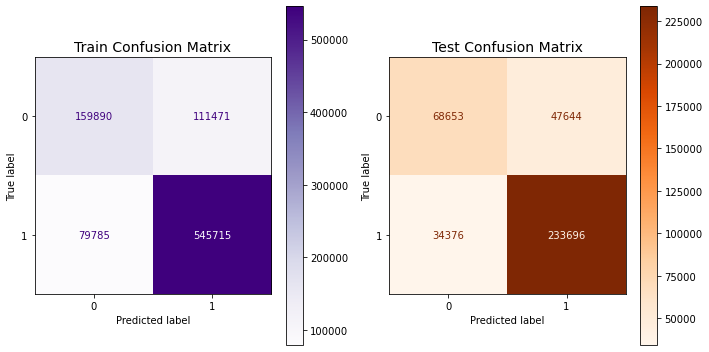

In [52]:
# Building modeling criteria
features = vet[vet[veteran_e].drop(['HINS6_2', 'MLPA_0', 'MLPA_1', 'MLPB_1', 'MLPB_0','VPS_1', 'VPS_2', 
                                        'VPS_3', 'VPS_4', 'VPS_5', 'VPS_6', 'VPS_7', 'VPS_8', 'VPS_9', 'VPS_10', 
                                        'VPS_11', 'VPS_12', 'VPS_13', 'VPS_14', 'VPS_15', 'MLPE_0', 'MLPE_1',
                                        'MLPFG_0', 'MLPFG_1', 'MLPH_0', 'MLPH_1', 'MLPI_0', 'MLPI_1', 'MLPJ_0', 
                                        'MLPK_0', 'ESR_5', 'MLPJ_1', 'MLPK_1', 'ESR_2', 'ESR_3', 'MLPCD_0', 
                                        'MIL_3', 'MLPCD_1', 'FHINS6P'], axis=1).columns]

# Split and Scale
y_train, y_test, X_train_sc, X_test_sc, Z_train, Z_test = split_scaler(features, vet['HINS6_2'])

# Logitistice Regression (scaled)
var_coef_vet = classifier(LogisticRegression(n_jobs=-1), y_train, y_test, X_train_sc, X_test_sc)

In [53]:
# Creating a constant for intercept analysis
exog = sm.add_constant(X_train_sc)

# Checking coeffiecients with Stats Models
model = sm.Logit(y_train, exog).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.456930
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                HINS6_2   No. Observations:               896861
Model:                          Logit   Df Residuals:                   896852
Method:                           MLE   Df Model:                            8
Date:                Tue, 14 Jul 2020   Pseudo R-squ.:                  0.2546
Time:                        20:15:57   Log-Likelihood:            -4.0980e+05
converged:                       True   LL-Null:                   -5.4980e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1677      0.003    349.953      0.000       1.161       1.174
DRAT          -0.1987      0.010    -20.435      0.000      -0.218      -0.180
DRATX_2        0.6392      0.010     65.754      0.000       0.620       0.658
MIL_2         -0.7835      0.005   -152.666      0.000      -0.794      -0.773
ESR_1          0.2574      0.003     90.654      0.000       0.252       0.263
ESR_4          0.1995      0.008     26.398      0.000       0.185       0.214
FHINS5C       -0.1815      0.003    -63.000      0.000      -0.187      -0.176
FHINS5P       -0.6812      0.003   -242.491      0.000      -0.687      -0.676
FMILSP         0.1901      0.003     67.535      0.000       0.185       0.196
==============================================================================
"""

## Classify VA enrollment based on Health and Wellness Features
---
This group of features did not perform as well, but with training and test scores decent fit with minimal variance.  

 Training Score :                      0.7726816084097758
 Test Score :                          0.7727496234087556
 Cross Valditation Score:              0.772681608409776
 Intercept:                            [0.95150919]


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.72      0.41      0.52    116297
           1       0.78      0.93      0.85    268072

    accuracy                           0.77    384369
   macro avg       0.75      0.67      0.69    384369
weighted avg       0.76      0.77      0.75    384369




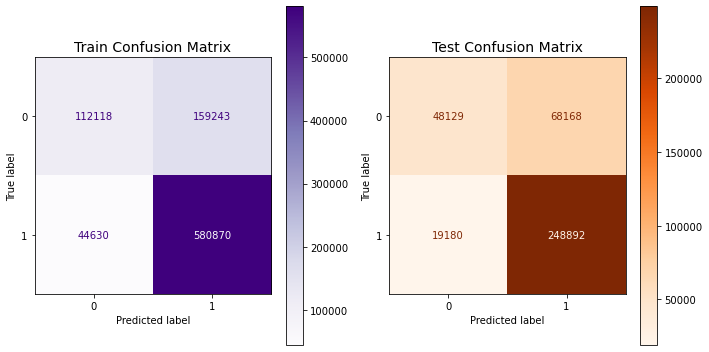

In [39]:
# Building modeling criteria
features = vet[vet[health_e].drop(['HINS6_2', 'DEYE', 'HICOV_2'], axis=1).columns]

# Split and Scale
y_train1, y_test1, X_train_sc1, X_test_sc1, Z_train1, Z_test1 = split_scaler(features, vet['HINS6_2'])

# Logitistice Regression (scaled)
var_coef_health = classifier(LogisticRegression(n_jobs=-1), y_train1, y_test1, X_train_sc1, X_test_sc1)

In [40]:
# Creating a constant for intercept analysis
exog1 = sm.add_constant(X_train_sc1)

# Checking coeffiecients with Stats Models
model1 = sm.Logit(y_train1, exog1, missing='drop').fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 0.513437
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                HINS6_2   No. Observations:               896861
Model:                          Logit   Df Residuals:                   896848
Method:                           MLE   Df Model:                           12
Date:                Tue, 14 Jul 2020   Pseudo R-squ.:                  0.1625
Time:                        19:50:14   Log-Likelihood:            -4.6048e+05
converged:                       True   LL-Null:                   -5.4980e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9515      0.003    361.893      0.000       0.946       0.957
DDRS          -0.0383      0.003    -11.993      0.000      -0.045      -0.032
DEAR_2         0.0227      0.003      6.624      0.000       0.016       0.029
DOUT_2        -0.0271      0.003     -7.977      0.000      -0.034      -0.020
DPHY_2         0.0355      0.004      9.550      0.000       0.028       0.043
DRAT          -0.8437      0.003   -332.327      0.000      -0.849      -0.839
DREM_2         0.0458      0.003     15.691      0.000       0.040       0.052
HINS1_2       -0.0750      0.003    -27.159      0.000      -0.080      -0.070
HINS2_2        0.1146      0.003     43.941      0.000       0.110       0.120
HINS3_2        0.2854      0.003     96.250      0.000       0.280       0.291
HINS4_2        0.0951      0.003     37.847      0.000       0.090       0.100
HINS5_2        0.0944      0.003     35.548      0.000       0.089       0.100
DIS            0.1768      0.005     36.950      0.000       0.167       0.186
==============================================================================
"""

In [41]:
log_prob(model1)

Odds veteran will NOT enroll: 
 



,index,0,Odds,Probability
0,const,0.951503,2.589598,0.721417
1,DDRS,-0.038342,0.962383,0.490416
2,DEAR_2,0.022737,1.022997,0.505684
3,DOUT_2,-0.027139,0.973226,0.493216
4,DPHY_2,0.035454,1.036090,0.508863
5,DRAT,-0.843724,0.430106,0.300751
6,DREM_2,0.045784,1.046848,0.511444
7,HINS1_2,-0.075049,0.927698,0.481247
8,HINS2_2,0.114627,1.121454,0.528625
9,HINS3_2,0.285403,1.330298,0.570870


## Classify VA enrollment based on Work and Income Features
---


 Training Score :                      0.7162626092560609
 Test Score :                          0.7160827225920925
 Cross Valditation Score:              0.7162603792560943
 Intercept:                            [0.93691545]


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.67      0.12      0.20    116297
           1       0.72      0.97      0.83    268072

    accuracy                           0.72    384369
   macro avg       0.70      0.55      0.52    384369
weighted avg       0.70      0.72      0.64    384369




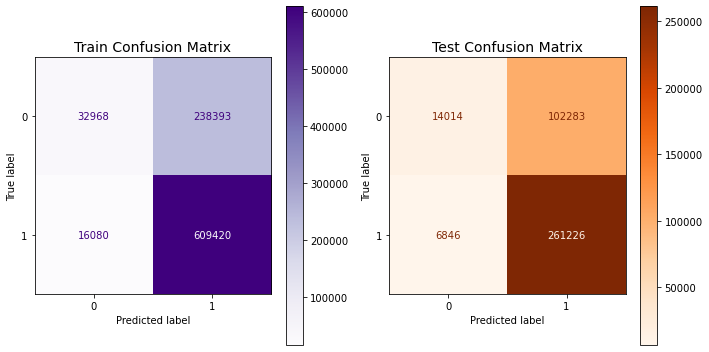

In [14]:
# Building modeling criteria
features = vet[vet[work_income_e].drop(['COW_1', 'COW_2', 'COW_3', 'COW_4', 'COW_5', 'COW_6', 'COW_7', 
                                            'COW_8', 'COW_9', 'WKW_1', 'WKW_2', 'WKW_3', 'WKW_4', 'WKW_5', 
                                            'WKW_6', 'WKL', 'PERNP_adj', 'PAP_adj', 'RETP_adj', 'SEMP_adj',
                                            'SSIP_adj', 'SSP_adj', 'WAGP_adj'], axis=1).columns]

# Split and Scale
y_train2, y_test2, X_train_sc2, X_test_sc2, Z_train2, Z_test2 = split_scaler(features, vet['HINS6_2'])

# Logitistice Regression (scaled)
var_coef_work = classifier(LogisticRegression(n_jobs=-1), y_train2, y_test2, X_train_sc2, X_test_sc2)

In [15]:
# Creating a constant for intercept analysis
exog2 = sm.add_constant(X_train_sc2)

# Checking coeffiecients with Stats Models
model2 = sm.Logit(y_train2, exog2, missing='drop').fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.569802
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                HINS6_2   No. Observations:               896861
Model:                          Logit   Df Residuals:                   896846
Method:                           MLE   Df Model:                           14
Date:                Tue, 14 Jul 2020   Pseudo R-squ.:                 0.07051
Time:                        18:47:04   Log-Likelihood:            -5.1103e+05
converged:                       True   LL-Null:                   -5.4980e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9369      0.003    341.831      0.000       0.932       0.942
INTP_adj       0.0203      0.003      5.957      0.000       0.014       0.027
OIP_adj       -0.4430      0.003   -160.672      0.000      -0.448      -0.438
NWLK_1        -0.0336      0.004     -9.085      0.000      -0.041      -0.026
NWLK_2        -0.0485      0.005     -9.975      0.000      -0.058      -0.039
WKHP           0.0888      0.006     15.000      0.000       0.077       0.100
WRK_1          0.0400      0.007      5.460      0.000       0.026       0.054
WRK_2         -0.2179      0.006    -34.024      0.000      -0.230      -0.205
PINCP_adj      0.1213      0.004     29.268      0.000       0.113       0.129
POVPIP         0.1659      0.003     53.556      0.000       0.160       0.172
ESR_1         -0.1520      0.010    -15.806      0.000      -0.171      -0.133
ESR_2         -0.0160      0.003     -6.072      0.000      -0.021      -0.011
ESR_3          0.0138      0.004      3.632      0.000       0.006       0.021
ESR_4          0.4892      0.008     61.545      0.000       0.474       0.505
ESR_5          0.0531      0.006      9.233      0.000       0.042       0.064
==============================================================================
"""

In [16]:
log_prob(model2)

Odds veteran will NOT enroll: 
 



,index,0,Odds,Probability
0,const,0.936927,2.552127,0.718479
1,INTP_adj,0.020253,1.020459,0.505063
2,OIP_adj,-0.443005,0.642104,0.391025
3,NWLK_1,-0.033640,0.966919,0.491591
4,NWLK_2,-0.048473,0.952683,0.487884
5,WKHP,0.088850,1.092916,0.522198
6,WRK_1,0.040048,1.040861,0.510011
7,WRK_2,-0.217907,0.804200,0.445738
8,PINCP_adj,0.121259,1.128918,0.530278
9,POVPIP,0.165926,1.180486,0.541387


## Classify VA enrollment based on Ethnicity Features
---


 Training Score :                      0.6974324895385127
 Test Score :                          0.697433976205157
 Cross Valditation Score:              0.6974324895385128
 Intercept:                            [0.83729009]


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    116297
           1       0.70      1.00      0.82    268072

    accuracy                           0.70    384369
   macro avg       0.35      0.50      0.41    384369
weighted avg       0.49      0.70      0.57    384369




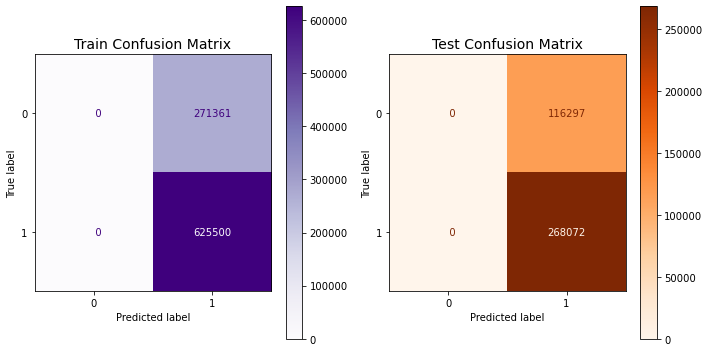

In [17]:
# Building modeling criteria
features = vet[vet[ethnicity_e].drop(['CIT_2', 'CIT_3', 'ENG_1', 'ENG_2', 'ENG_3', 'ENG_4', 'HISP', 'RAC1P',
                                         'RACASN', 'RACNH', 'RACNUM', 'RACSOR', 'RACWHT', 'LANX'], 
                                         axis=1).columns]

# Split and Scale
y_train3, y_test3, X_train_sc3, X_test_sc3, Z_train3, Z_test3 = split_scaler(features, vet['HINS6_2'])

# Logitistice Regression (scaled)
var_coef_work = classifier(LogisticRegression(n_jobs=-1), y_train3, y_test3, X_train_sc3, X_test_sc3)

In [18]:
# Creating a constant for intercept analysis
exog3 = sm.add_constant(X_train_sc3)

# Checking coeffiecients with Stats Models
model3 = sm.Logit(y_train3, exog3, missing='drop').fit()
model3.summary()

Optimization terminated successfully.
         Current function value: 0.611781
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                HINS6_2   No. Observations:               896861
Model:                          Logit   Df Residuals:                   896855
Method:                           MLE   Df Model:                            5
Date:                Tue, 14 Jul 2020   Pseudo R-squ.:                0.002028
Time:                        18:47:14   Log-Likelihood:            -5.4868e+05
converged:                       True   LL-Null:                   -5.4980e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8373      0.002    363.502      0.000       0.833       0.842
CIT_4          0.0303      0.002     12.653      0.000       0.026       0.035
CIT_5          0.0352      0.003     13.458      0.000       0.030       0.040
RACAIAN       -0.0339      0.002    -15.356      0.000      -0.038      -0.030
RACBLK        -0.0898      0.002    -40.586      0.000      -0.094      -0.085
FCITP          0.0102      0.002      4.324      0.000       0.006       0.015
==============================================================================
"""

In [19]:
log_prob(model3)

Odds veteran will NOT enroll: 
 



,index,0,Odds,Probability
0,const,0.837289,2.310095,0.697894
1,CIT_4,0.030327,1.030791,0.507581
2,CIT_5,0.035217,1.035844,0.508803
3,RACAIAN,-0.033885,0.966683,0.491530
4,RACBLK,-0.089763,0.914148,0.477574
5,FCITP,0.010200,1.010252,0.502550


## Classify VA enrollment based on Lifestyle Features
---
None of these features 

 Training Score :                      0.6974324895385127
 Test Score :                          0.697433976205157
 Cross Valditation Score:              0.6974324895385128
 Intercept:                            [0.85571746]


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    116297
           1       0.70      1.00      0.82    268072

    accuracy                           0.70    384369
   macro avg       0.35      0.50      0.41    384369
weighted avg       0.49      0.70      0.57    384369




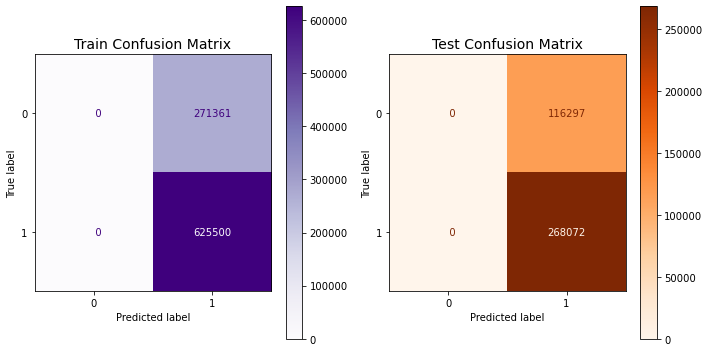

In [20]:
# Building modeling criteria
features = vet[vet[lifestyle_e].drop(['MAR_1', 'MAR_2', 'MAR_4', 'MAR_3', 'MARHD_1', 'MARHD_2', 'MARHT_1',
                                     'MARHT_2', 'MARHT_3', 'MARHW_1', 'MARHW_2', 'MSP_1', 'MSP_2', 'MSP_3',
                                     'MSP_4', 'MSP_5'], axis=1).columns]

# Split and Scale
y_train4, y_test4, X_train_sc4, X_test_sc4, Z_train4, Z_test4 = split_scaler(features, vet['HINS6_2'])

# Logitistice Regression (scaled)
var_coef_work = classifier(LogisticRegression(n_jobs=-1), y_train4, y_test4, X_train_sc4, X_test_sc4)

In [21]:
# Creating a constant for intercept analysis
exog4 = sm.add_constant(X_train_sc4)

# Checking coeffiecients with Stats Models
model4 = sm.Logit(y_train4, exog4, missing='drop').fit()
model4.summary()

Optimization terminated successfully.
         Current function value: 0.603567
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                HINS6_2   No. Observations:               896861
Model:                          Logit   Df Residuals:                   896859
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 Jul 2020   Pseudo R-squ.:                 0.01543
Time:                        18:47:23   Log-Likelihood:            -5.4132e+05
converged:                       True   LL-Null:                   -5.4980e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8557      0.002    365.158      0.000       0.851       0.860
JWRIP          0.3158      0.003    125.902      0.000       0.311       0.321
==============================================================================
"""

In [22]:
log_prob(model4)

Odds veteran will NOT enroll: 
 



,index,0,Odds,Probability
0,const,0.855718,2.353063,0.701765
1,JWRIP,0.315812,1.371372,0.578303


## Classify VA enrollment based on Location Features
---
Nothing of interest in this group.  Both state(ST) and PUMA are not true categorizations.  We can effectively say that location is not significant.

 Training Score :                      0.6974324895385127
 Test Score :                          0.697433976205157
 Cross Valditation Score:              0.6974324895385128
 Intercept:                            [0.83784222]


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    116297
           1       0.70      1.00      0.82    268072

    accuracy                           0.70    384369
   macro avg       0.35      0.50      0.41    384369
weighted avg       0.49      0.70      0.57    384369




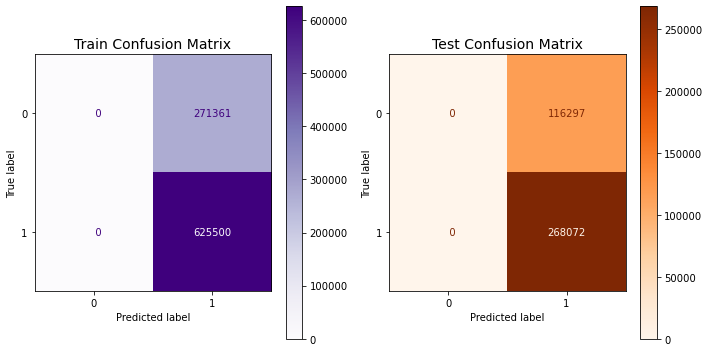

In [23]:
# Building modeling criteria
features = vet[vet[location_e].drop([], axis=1).columns]

# Split and Scale
y_train5, y_test5, X_train_sc5, X_test_sc5, Z_train5, Z_test5 = split_scaler(features, vet['HINS6_2'])

# Logitistice Regression (scaled)
var_coef_work = classifier(LogisticRegression(n_jobs=-1), y_train5, y_test5, X_train_sc5, X_test_sc5)

In [24]:
# Creating a constant for intercept analysis
exog5 = sm.add_constant(X_train_sc5)

# Checking coeffiecients with Stats Models
model5 = sm.Logit(y_train5, exog5, missing='drop').fit()
model5.summary()

Optimization terminated successfully.
         Current function value: 0.611624
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                HINS6_2   No. Observations:               896861
Model:                          Logit   Df Residuals:                   896850
Method:                           MLE   Df Model:                           10
Date:                Tue, 14 Jul 2020   Pseudo R-squ.:                0.002284
Time:                        18:47:47   Log-Likelihood:            -5.4854e+05
converged:                       True   LL-Null:                   -5.4980e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8378      0.002    363.560      0.000       0.833       0.842
DIVISION_2    -0.0053      0.004     -1.272      0.203      -0.013       0.003
DIVISION_3    -0.0200        nan        nan        nan         nan         nan
DIVISION_4    -0.0527        nan        nan        nan         nan         nan
DIVISION_5    -0.0275        nan        nan        nan         nan         nan
DIVISION_6    -0.0256        nan        nan        nan         nan         nan
DIVISION_7    -0.0416        nan        nan        nan         nan         nan
DIVISION_8    -0.0444   1.65e+04  -2.69e-06      1.000   -3.23e+04    3.23e+04
DIVISION_9    -0.0049   2.09e+04  -2.37e-07      1.000   -4.09e+04    4.09e+04
REGION_2      -0.0506        nan        nan        nan         nan         nan
REGION_3      -0.0635        nan        nan        nan         nan         nan
REGION_4      -0.0334    2.5e+04  -1.33e-06      1.000    -4.9e+04     4.9e+04
ST            -0.0128      0.003     -4.732      0.000      -0.018      -0.008
PUMA           0.0788      0.003     28.368      0.000       0.073       0.084
==============================================================================
"""

In [25]:
log_prob(model5)

Odds veteran will NOT enroll: 
 



,index,0,Odds,Probability
0,const,0.837844,2.311377,0.698011
1,DIVISION_2,-0.005308,0.994706,0.498673
2,DIVISION_3,-0.019952,0.980246,0.495012
3,DIVISION_4,-0.052701,0.948663,0.486828
4,DIVISION_5,-0.027480,0.972894,0.493130
5,DIVISION_6,-0.025564,0.974760,0.493609
6,DIVISION_7,-0.041563,0.959289,0.489611
7,DIVISION_8,-0.044362,0.956607,0.488911
8,DIVISION_9,-0.004950,0.995062,0.498763
9,REGION_2,-0.050588,0.950671,0.487356


## Classify VA enrollment based on General Demographic Features
---


 Training Score :                      0.6971693495424598
 Test Score :                          0.697048929544266
 Cross Valditation Score:              0.6971559695426605
 Intercept:                            [0.85568524]


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.39      0.00      0.00    116297
           1       0.70      1.00      0.82    268072

    accuracy                           0.70    384369
   macro avg       0.54      0.50      0.41    384369
weighted avg       0.60      0.70      0.57    384369




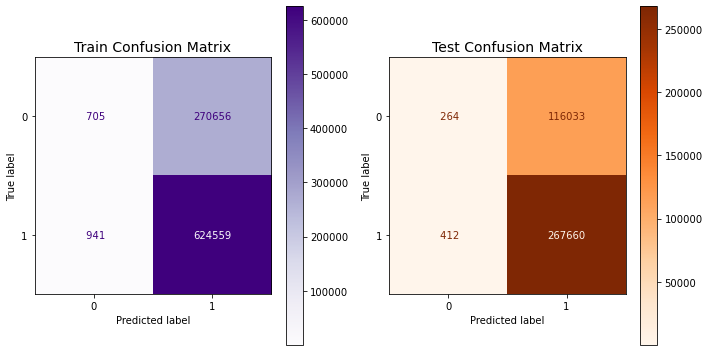

In [26]:
# Building modeling criteria
features = vet[vet[general_e].drop(['MAR_2'], axis=1).columns]

# Split and Scale
y_train6, y_test6, X_train_sc6, X_test_sc6, Z_train6, Z_test6 = split_scaler(features, vet['HINS6_2'])

# Logitistice Regression (scaled)
var_coef_work = classifier(LogisticRegression(n_jobs=-1), y_train6, y_test6, X_train_sc6, X_test_sc6)

In [27]:
# Creating a constant for intercept analysis
exog6 = sm.add_constant(X_train_sc6)

# Checking coeffiecients with Stats Models
model6 = sm.Logit(y_train6, exog6, missing='drop').fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.602181
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                HINS6_2   No. Observations:               896861
Model:                          Logit   Df Residuals:                   896849
Method:                           MLE   Df Model:                           11
Date:                Tue, 14 Jul 2020   Pseudo R-squ.:                  0.2894
Time:                        18:47:57   Log-Likelihood:            -3.9068e+05
converged:                       True   LL-Null:                   -5.4980e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1260      0.003    331.638      0.000       1.119       1.133
DRAT          -0.1990      0.010    -19.895      0.000      -0.219      -0.179
DRATX_2        0.6165      0.010     61.704      0.000       0.597       0.636
MIL_2         -1.1366      0.051    -22.269      0.000      -1.237      -1.037
MIL_3         -0.2852   4.65e+04  -6.13e-06      1.000   -9.12e+04    9.12e+04
MLPCD_0        0.0899   6.38e+04   1.41e-06      1.000   -1.25e+05    1.25e+05
MLPCD_1        0.1386   5.43e+04   2.55e-06      1.000   -1.06e+05    1.06e+05
ESR_1          0.2842      0.003     94.591      0.000       0.278       0.290
ESR_4          0.0945      0.026      3.694      0.000       0.044       0.145
FHINS5C       -0.2994      0.003    -96.963      0.000      -0.305      -0.293
FHINS5P       -1.3191      0.005   -249.736      0.000      -1.329      -1.309
FHINS6P        0.8624      0.005    170.010      0.000       0.852       0.872
FMILSP         0.0575      0.003     19.760      0.000       0.052       0.063
==============================================================================
"""

In [28]:
log_prob(model6)

Odds veteran will NOT enroll: 
 



,index,0,Odds,Probability
0,const,0.855686,2.352988,0.701759
1,AGEP,-0.267378,0.765384,0.433551
2,MAR_1,0.090584,1.094813,0.522630
3,MAR_3,-0.131940,0.876394,0.467063
4,MAR_4,-0.045388,0.955627,0.488655
5,SEX_2,0.027620,1.028005,0.506905


## Classify VA enrollment based on Education Features
---


 Training Score :                      0.6974324895385127
 Test Score :                          0.697433976205157
 Cross Valditation Score:              0.6974324895385128
 Intercept:                            [0.8404329]


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    116297
           1       0.70      1.00      0.82    268072

    accuracy                           0.70    384369
   macro avg       0.35      0.50      0.41    384369
weighted avg       0.49      0.70      0.57    384369




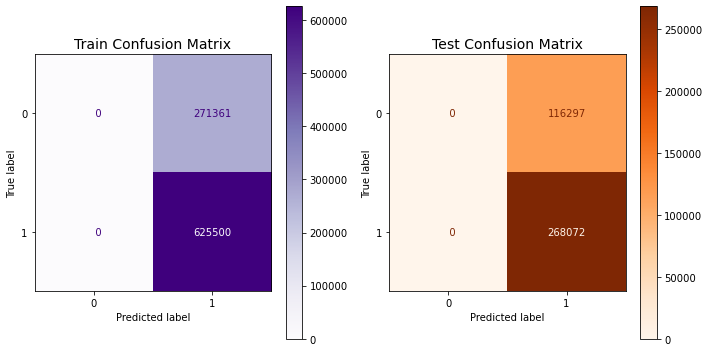

In [29]:
# Building modeling criteria
features = vet[vet[education_e].drop(['SCHL_8', 'SCHL_9', 'SCHL_10', 'SCHL_14', 'SCHL_16'], axis=1).columns]

# Split and Scale
y_train7, y_test7, X_train_sc7, X_test_sc7, Z_train7, Z_test7 = split_scaler(features, vet['HINS6_2'])

# Logitistice Regression (scaled)
var_coef_work = classifier(LogisticRegression(n_jobs=-1), y_train7, y_test7, X_train_sc7, X_test_sc7)

In [30]:
# Creating a constant for intercept analysis
exog7 = sm.add_constant(X_train_sc7)

# Checking coeffiecients with Stats Models
model7 = sm.Logit(y_train7, exog7, missing='drop').fit()
model7.summary()

Optimization terminated successfully.
         Current function value: 0.610207
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                HINS6_2   No. Observations:               896861
Model:                          Logit   Df Residuals:                   896846
Method:                           MLE   Df Model:                           14
Date:                Tue, 14 Jul 2020   Pseudo R-squ.:                0.004595
Time:                        18:48:38   Log-Likelihood:            -5.4727e+05
converged:                       True   LL-Null:                   -5.4980e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8406      0.002    363.802      0.000       0.836       0.845
SCHL_11       -0.0332      0.002    -14.983      0.000      -0.038      -0.029
SCHL_12       -0.0241      0.002    -10.787      0.000      -0.028      -0.020
SCHL_13       -0.0254      0.002    -11.269      0.000      -0.030      -0.021
SCHL_15       -0.0150      0.002     -6.548      0.000      -0.020      -0.011
SCHL_17       -0.0810      0.002    -34.610      0.000      -0.086      -0.076
SCHL_18       -0.0259      0.003    -10.283      0.000      -0.031      -0.021
SCHL_19       -0.0516      0.003    -19.299      0.000      -0.057      -0.046
SCHL_20       -0.0534      0.003    -21.320      0.000      -0.058      -0.049
SCHL_21       -7.8668      0.768    -10.244      0.000      -9.372      -6.362
SCHL_22       -5.7243      0.559    -10.238      0.000      -6.820      -4.629
SCHL_23       -3.1630      0.314    -10.082      0.000      -3.778      -2.548
SCHL_24       -2.3636      0.233    -10.162      0.000      -2.819      -1.908
SCIENGP        7.2710      0.428     17.001      0.000       6.433       8.109
SCIENGRLP      2.3062      0.739      3.121      0.002       0.858       3.754
==============================================================================
"""

In [31]:
log_prob(model7)

Odds veteran will NOT enroll: 
 



,index,0,Odds,Probability
0,const,0.840613,2.317788,0.698594
1,SCHL_11,-0.033218,0.967328,0.491696
2,SCHL_12,-0.024055,0.976232,0.493987
3,SCHL_13,-0.025424,0.974896,0.493644
4,SCHL_15,-0.015027,0.985085,0.496243
5,SCHL_17,-0.081043,0.922154,0.479750
6,SCHL_18,-0.025934,0.974400,0.493517
7,SCHL_19,-0.051569,0.949738,0.487110
8,SCHL_20,-0.053423,0.947979,0.486648
9,SCHL_21,-7.866812,0.000383,0.000383


## Final Combined Model
---

 Training Score :                      0.7936135030957975
 Test Score :                          0.7928787181068192
 Cross Valditation Score:              0.793583398096249
 Intercept:                            [1.20441375]


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.70      0.56      0.62    116297
           1       0.82      0.89      0.86    268072

    accuracy                           0.79    384369
   macro avg       0.76      0.73      0.74    384369
weighted avg       0.79      0.79      0.79    384369




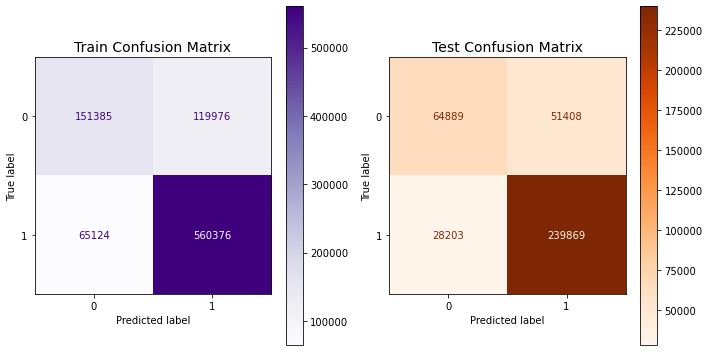

In [45]:
# Building modeling criteria for the top performing features

top_features = ['DRAT', 'DRATX', 'MIL', 'MLPCD_0', 'MLPCD_1', 'ESR_1', 'ESR_4',   #VETERAN FEATURES
                'FHINS5C', 'FHINS5P', 'FMILSP', 
                'DDRS', 'DEAR_2', 'DEYE', 'DOUT_2', 'DPHY_2', 'DREM_2', 'HINS1_2',#HEALTH FEATURES
                'HINS2_2', 'HINS3_2', 'HINS4_2', 'HINS5_2', 'DIS', 'HICOV_2', 
                'INTP_adj', 'OIP_adj', 'PINCP_adj', 'NWLK_1', 'NWLK_2', 'WKHP',   #WORK/INCOME FEATURES
                'WRK_1', 'WRK_2', 'POVPIP', 'ESR_2', 'ESR_3', 'ESR_5',
                'CIT_4', 'CIT_5', 'RACBLK', 'FCITP', 'RACAIAN',                   #ETHNICITY FEATURES
                'AGEP', 'MAR_1', 'MAR_4', 'SEX_2',                                #GENERAL FEATURES
                'SCHL_11', 'SCHL_12', 'SCHL_13', 'SCHL_17', 'SCHL_18', 'SCHL_19', #EDUCATION FEATURES
                'SCHL_20', 'SCHL_21', 'SCHL_22', 'SCHL_23', 'SCHL_24', 'SCIENGP']

features = vet[vet[top_features].drop(['ESR_1', 'ESR_4','FHINS5C', 'DEYE', 'HINS5_2', 'WKHP', 'CIT_5',
                                      'MAR_4', 'SCHL_11', 'SCHL_12', 'SCHL_13', 'INTP_adj', 'HICOV_2',
                                      'ESR_5'], axis=1).columns]

# Split and Scale
y_train8, y_test8, X_train_sc8, X_test_sc8, Z_train8, Z_test8 = split_scaler(features, vet['HINS6_2'])

# Logitistice Regression (scaled)
var_coef_work = classifier(LogisticRegression(n_jobs=-1), y_train8, y_test8, X_train_sc8, X_test_sc8)

In [46]:
# Creating a constant for intercept analysis
exog8 = sm.add_constant(X_train_sc8)

# Checking coeffiecients with Stats Models
model8 = sm.Logit(y_train8, exog8, missing='drop').fit()
model8.summary()

Optimization terminated successfully.
         Current function value: 0.441653
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                HINS6_2   No. Observations:               896861
Model:                          Logit   Df Residuals:                   896818
Method:                           MLE   Df Model:                           42
Date:                Tue, 14 Jul 2020   Pseudo R-squ.:                  0.2795
Time:                        20:15:35   Log-Likelihood:            -3.9610e+05
converged:                       True   LL-Null:                   -5.4980e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2044      0.003    351.666      0.000       1.198       1.211
DRAT          -0.2493      0.010    -24.831      0.000      -0.269      -0.230
DRATX          0.5891      0.010     58.838      0.000       0.570       0.609
MIL           -1.0669      0.015    -69.093      0.000      -1.097      -1.037
MLPCD_0       -2.2286      0.019   -116.258      0.000      -2.266      -2.191
MLPCD_1       -1.9161      0.016   -117.008      0.000      -1.948      -1.884
FHINS5P       -0.7470      0.003   -236.432      0.000      -0.753      -0.741
FMILSP         0.1213      0.005     26.758      0.000       0.112       0.130
DDRS          -0.0184      0.003     -5.279      0.000      -0.025      -0.012
DEAR_2         0.0527      0.004     14.035      0.000       0.045       0.060
DOUT_2        -0.0355      0.004     -9.603      0.000      -0.043      -0.028
DPHY_2         0.0289      0.004      7.148      0.000       0.021       0.037
DREM_2         0.0345      0.003     10.876      0.000       0.028       0.041
HINS1_2       -0.2213      0.003    -68.562      0.000      -0.228      -0.215
HINS2_2       -0.0104      0.003     -3.548      0.000      -0.016      -0.005
HINS3_2        0.1211      0.005     23.471      0.000       0.111       0.131
HINS4_2       -0.0386      0.003    -13.795      0.000      -0.044      -0.033
DIS            0.1205      0.005     23.162      0.000       0.110       0.131
OIP_adj       -0.1581      0.003    -54.230      0.000      -0.164      -0.152
PINCP_adj      0.1311      0.004     31.161      0.000       0.123       0.139
NWLK_1        -0.0291      0.004     -6.768      0.000      -0.038      -0.021
NWLK_2        -0.0492      0.006     -8.792      0.000      -0.060      -0.038
WRK_1         -0.2382      0.007    -32.208      0.000      -0.253      -0.224
WRK_2         -0.2245      0.008    -27.991      0.000      -0.240      -0.209
POVPIP         0.1369      0.004     34.783      0.000       0.129       0.145
ESR_2         -0.0154      0.003     -5.472      0.000      -0.021      -0.010
ESR_3         -0.0112      0.004     -2.599      0.009      -0.020      -0.003
CIT_4          0.0211      0.003      7.344      0.000       0.015       0.027
RACBLK        -0.0609      0.003    -21.765      0.000      -0.066      -0.055
FCITP          0.0101      0.004      2.550      0.011       0.002       0.018
RACAIAN       -0.0172      0.003     -6.254      0.000      -0.023      -0.012
AGEP           0.0401      0.005      7.769      0.000       0.030       0.050
MAR_1          0.1712      0.003     57.754      0.000       0.165       0.177
SEX_2          0.0303      0.003     10.002      0.000       0.024       0.036
SCHL_17       -0.0357      0.003    -12.718      0.000      -0.041      -0.030
SCHL_18       -0.0238      0.003     -7.764      0.000      -0.030      -0.018
SCHL_19       -0.0560      0.003    -17.383      0.000      -0.062      -0.050
SCHL_20       -0.0457      0.003    -14.790      0.000      -0.052      -0.040
SC

In [47]:
results = log_prob(model8)
results

Odds veteran will NOT enroll: 
 



,index,0,Odds,Probability
0,const,1.204439,3.334887,0.769313
1,DRAT,-0.249319,0.779331,0.437991
2,DRATX,0.589140,1.802438,0.643168
3,MIL,-1.066918,0.344067,0.255990
4,MLPCD_0,-2.228562,0.107683,0.097215
5,MLPCD_1,-1.916064,0.147185,0.128301
6,FHINS5P,-0.746993,0.473789,0.321477
7,FMILSP,0.121292,1.128955,0.530286
8,DDRS,-0.018366,0.981802,0.495409
9,DEAR_2,0.052730,1.054145,0.513179


In [48]:

# #probs = results.drop(labels=['Odds']) #, axis=1)
# plt.figure(figsize=(12,10))
# sns.heatmap(results['index', 'Probability'], annot=True, cmap="rainbow");

In [49]:
# # Looking at top preforming features that indicate a Canon post
# results = results.T
# probs = results.drop(labels=0, axis=1)
# top_features = results[results['index']]


# plt.figure(figsize=(4,8))
# sns.heatmap(top_features.sort_values(probs['Probability'], ascending=False), annot=True);

In [50]:
results.dtypes

index           object
0              float64
Odds           float64
Probability    float64
dtype: object

In [56]:
vet['HINS6_2'].mean()

0.6974329355385059